In [ ]:
import zipfile
import os

# Define the path to the ZIP file and the extraction directory
zip_file_path = '/content/silver_layer (2).zip'
extract_to_directory = '/content/dataset'

# Ensure the extraction directory exists
os.makedirs(extract_to_directory, exist_ok=True)

# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print(f"Files extracted to {extract_to_directory}")


Files extracted to /content/dataset


In [ ]:
import zipfile
import os

# Define the path to the ZIP file and the extraction directory
zip_file_path = '/content/validation.zip'
extract_to_directory = '/content/val_dataset'

# Ensure the extraction directory exists
os.makedirs(extract_to_directory, exist_ok=True)

# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_directory)

print(f"Files extracted to {extract_to_directory}")


Files extracted to /content/val_dataset


In [ ]:
import torch
print(torch.__version__)


2.5.1+cu121


In [ ]:
torch.cuda.is_available()

True

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import os
from time import time

# Define the EmotionDataset
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('L')  # Load as grayscale
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Define the training and validation pipelines
def get_data_loaders(data_dir, batch_size, transform):
    image_paths = []
    labels = []

    # Assumes data is organized in subdirectories by class
    class_names = sorted(os.listdir(data_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    for cls_name in class_names:
        class_dir = os.path.join(data_dir, cls_name)
        for file_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, file_name))
            labels.append(class_to_idx[cls_name])

    dataset = EmotionDataset(image_paths, labels, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader, class_to_idx

# Preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Single-channel normalization
])


# Model definition
def get_model(num_classes):
    model = models.resnet152(pretrained=True)
    # Modify the first convolutional layer for single-channel input
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Adjust the fully connected layer
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Training function
# Training function with accuracy tracking and epoch start message
def train_and_validate_model(
    model, train_loader, val_loader, num_epochs, criterion, optimizer, device, num_classes
):
    model.to(device)
    for epoch in range(num_epochs):
        # Training phase
        start_time = time()
        print(f"Starting Epoch [{epoch + 1}/{num_epochs}]...")

        model.train()
        train_running_loss = 0.0
        train_correct_per_class = [0] * num_classes
        train_total_per_class = [0] * num_classes

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()

            # Calculate accuracy per class
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                label = labels[i].item()
                train_total_per_class[label] += 1
                if predicted[i].item() == label:
                    train_correct_per_class[label] += 1

        # Compute training metrics
        train_epoch_loss = train_running_loss / len(train_loader)
        train_epoch_accuracy = 100 * sum(train_correct_per_class) / sum(train_total_per_class)

        print(f"Training Loss: {train_epoch_loss:.4f}, Accuracy: {train_epoch_accuracy:.2f}%")
        print("Training Class-wise accuracy:")
        for cls_idx in range(num_classes):
            accuracy = (
                100 * train_correct_per_class[cls_idx] / train_total_per_class[cls_idx]
                if train_total_per_class[cls_idx] > 0
                else 0
            )
            print(f"  Class {cls_idx}: Accuracy: {accuracy:.2f}% (Correct: {train_correct_per_class[cls_idx]}/{train_total_per_class[cls_idx]})")

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct_per_class = [0] * num_classes
        val_total_per_class = [0] * num_classes

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Calculate accuracy per class
                _, predicted = torch.max(outputs, 1)
                for i in range(len(labels)):
                    label = labels[i].item()
                    val_total_per_class[label] += 1
                    if predicted[i].item() == label:
                        val_correct_per_class[label] += 1

        # Compute validation metrics
        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = 100 * sum(val_correct_per_class) / sum(val_total_per_class)

        print(f"Validation Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_accuracy:.2f}%")
        print("Validation Class-wise accuracy:")
        for cls_idx in range(num_classes):
            accuracy = (
                100 * val_correct_per_class[cls_idx] / val_total_per_class[cls_idx]
                if val_total_per_class[cls_idx] > 0
                else 0
            )
            print(f"  Class {cls_idx}: Accuracy: {accuracy:.2f}% (Correct: {val_correct_per_class[cls_idx]}/{val_total_per_class[cls_idx]})")

        end_time = time()
        print(f"Epoch [{epoch + 1}/{num_epochs}] completed in {end_time - start_time:.2f}s\n")






train_data_dir = "/content/dataset/silver_layer"
val_data_dir = "/content/val_dataset/validation"

batch_size = 32
num_epochs = 15
learning_rate = 0.001
num_classes = 7
train_loader, _ = get_data_loaders(train_data_dir, batch_size, transform)
val_loader, _ = get_data_loaders(val_data_dir, batch_size, transform)
model = get_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_and_validate_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, num_classes)
torch.save(model.state_dict(), "/content/model_emotion_v3.pth")
print("Model saved as model_emotion_v1.pth")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 141MB/s]


Starting Epoch [1/15]...
Training Loss: 1.1280, Accuracy: 56.54%
Training Class-wise accuracy:
  Class 0: Accuracy: 20.75% (Correct: 499/2405)
  Class 1: Accuracy: 59.64% (Correct: 1491/2500)
  Class 2: Accuracy: 52.00% (Correct: 1313/2525)
  Class 3: Accuracy: 67.67% (Correct: 1702/2515)
  Class 4: Accuracy: 96.94% (Correct: 4028/4155)
  Class 5: Accuracy: 44.19% (Correct: 1096/2480)
  Class 6: Accuracy: 26.49% (Correct: 665/2510)
Validation Loss: 3.6006, Accuracy: 16.98%
Validation Class-wise accuracy:
  Class 0: Accuracy: 3.54% (Correct: 34/960)
  Class 1: Accuracy: 0.00% (Correct: 0/111)
  Class 2: Accuracy: 0.00% (Correct: 0/1018)
  Class 3: Accuracy: 1.42% (Correct: 26/1825)
  Class 4: Accuracy: 0.00% (Correct: 0/1216)
  Class 5: Accuracy: 95.43% (Correct: 1087/1139)
  Class 6: Accuracy: 6.65% (Correct: 53/797)
Epoch [1/15] completed in 611.94s

Starting Epoch [2/15]...
Training Loss: 0.7750, Accuracy: 70.61%
Training Class-wise accuracy:
  Class 0: Accuracy: 50.35% (Correct: 121

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


<ipython-input-9-8e8620463d25>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/model_emotion_v3.pth"))


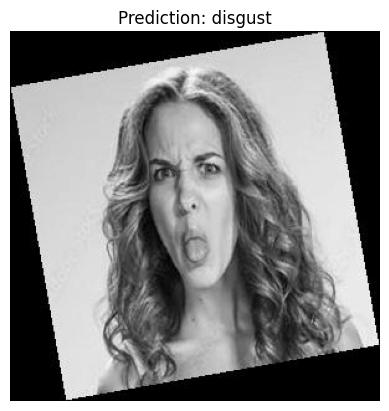

In [ ]:
# prompt: get random image from dataset and show its prediciton with displayed image and title as prediciton

import random
import matplotlib.pyplot as plt
from PIL import Image

# ... (Your existing code) ...

# Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("/content/model_emotion_v3.pth"))
model.to(device)
model.eval()

# Function to get a random image from the dataset and show its prediction
def predict_random_image(data_dir, model, device, class_to_idx):
  image_paths = []
  for cls_name in sorted(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, cls_name)
    for file_name in os.listdir(class_dir):
      image_paths.append(os.path.join(class_dir, file_name))

  random_image_path = random.choice(image_paths)
  img = Image.open(random_image_path).convert('L')
  img_tensor = transform(img).unsqueeze(0).to(device)

  with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs, 1)

  predicted_class_idx = predicted.item()
  idx_to_class = {v: k for k, v in class_to_idx.items()}
  predicted_class = idx_to_class[predicted_class_idx]

  plt.imshow(img, cmap='gray')
  plt.title(f"Prediction: {predicted_class}")
  plt.axis('off')
  plt.show()

# Get the class_to_idx mapping (you might need to adjust the data directory)
train_data_dir = "/content/dataset/silver_layer"
_, class_to_idx = get_data_loaders(train_data_dir, batch_size, transform)

# Predict and display a random image
predict_random_image(train_data_dir, model, device, class_to_idx)

<ipython-input-14-7a36f318552f>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


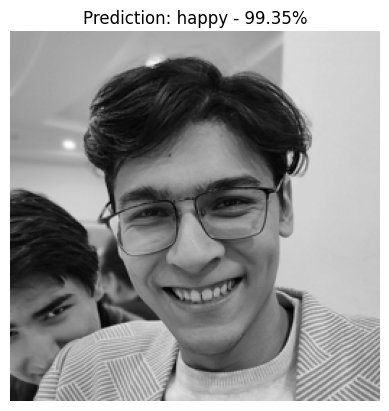

In [ ]:
# prompt: convert content/ava.jpg into 256 256 and grayscale and predict and display on title with image

# ... (Your existing code) ...

# Function to predict and display a specific image
def predict_image(image_path, model_path):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  img = Image.open(image_path).convert('L')
  img = img.resize((256, 256))  # Resize to 256x256
  img_tensor = transform(img).unsqueeze(0).to(device)

  model = get_model(num_classes)
  model.load_state_dict(torch.load(model_path))
  model.to(device)
  model.eval()

  class_to_idx = {'angry': 0, 'disgust': 1,'fear': 2,'happy': 3,'neutral': 4,'sad': 5,'surprise': 6}

  with torch.no_grad():
    outputs = model(img_tensor)
    _, predicted = torch.max(outputs, 1)
    predicted_probability = torch.softmax(outputs, dim=1)
    max_probability, _ = torch.max(predicted_probability, dim=1)
    predicted_probability = max_probability.item() * 100
  predicted_class_idx = predicted.item()
  idx_to_class = {v: k for k, v in class_to_idx.items()}
  predicted_class = idx_to_class[predicted_class_idx]

  plt.imshow(img, cmap='gray')
  plt.title(f"Prediction: {predicted_class} - {predicted_probability:.2f}%")
  plt.axis('off')
  plt.show()

# Example usage with 'content/ava.jpg'
image_path = 'ava.jpg'
model_path = '/content/model_emotion_v3.pth'
predict_image(image_path, model_path)

In [ ]:
torch.save(model.state_dict(), "/content/model_emotion_v4.pth")

In [ ]:
class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt


class EmotionRecognition:
    def __init__(self, model_path, csv_path, gold_layer, device=None):
        self.model_path = model_path
        self.csv_path = csv_path
        self.gold_layer = gold_layer
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.transform = self.default_transform()
        self.model = self.build_model()
        self.load_model()

    @staticmethod
    def default_transform():
        return transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])  # Single-channel normalization
        ])

    def build_model(self):
        model = models.resnet18(pretrained=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, 7)  # Assuming 7 emotion classes
        return model

    def load_model(self):
        self.model.load_state_dict(torch.load(self.model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict(self, image_path):
        img = Image.open(image_path).convert('L')  # Grayscale
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        with torch.no_grad():
            outputs = self.model(img_tensor)
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.softmax(outputs, dim=1)
            max_probability, _ = torch.max(probabilities, dim=1)

        predicted_class_idx = predicted.item()
        predicted_probability = max_probability.item() * 100
        return predicted_class_idx, predicted_probability

    def save_prediction_image(self, image_path, predicted_class, predicted_probability):
        # Open the original image
        img = Image.open(image_path).convert('L')
        plt.imshow(img, cmap='gray')
        plt.title(f"{predicted_class} - {predicted_probability:.2f}%")
        plt.axis('off')

        # Save the image with the prediction in /gold_layer
        output_path = os.path.join(
            self.gold_layer,
            f"{os.path.basename(image_path).split('/')[-1].split('.')[0]}_predicted.jpg"
        )
        if not os.path.exists(self.gold_layer):
            os.makedirs(self.gold_layer)
        plt.savefig(output_path)
        plt.close()
        print(f"Prediction: {output_path}")
        return output_path

    def save_prediction_to_csv(self, image_name, predicted_class, predicted_probability):
        # Create or append to the CSV
        if not os.path.exists(self.csv_path):
            df = pd.DataFrame(columns=['file', 'predicted_class', 'predicted_probability'])
        else:
            df = pd.read_csv(self.csv_path)

        new_row = {
              'file': image_name,
              'predicted_class': predicted_class,
              'predicted_probability': predicted_probability
          }

        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        df.to_csv(self.csv_path, index=False)
        # print(f"Prediction saved to CSV: {self.csv_path}")

    def process_image(self, image_path):
        class_to_idx = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
        idx_to_class = {v: k for k, v in class_to_idx.items()}

        predicted_idx, predicted_prob = self.predict(image_path)
        predicted_class = idx_to_class[predicted_idx]

        # Save prediction to CSV
        self.save_prediction_to_csv(os.path.basename(image_path), predicted_class, predicted_prob)

        # Save prediction image to /gold_layer
        self.save_prediction_image(image_path, predicted_class, predicted_prob)

        # print(f"Processed {image_path}: {predicted_class} ({predicted_prob:.2f}%)")


# Example usage
if __name__ == "__main__":
    path = "/content/silver_layer/ava.jpg"  # Path to input image
    model = "/content/model_emotion_v4.pth"                # Path to model file
    csv_path = "/content/file.csv"              # Path to CSV file for predictions
    gold_layer = "/content/gold_layer"                  # Path to output images

    recognizer = EmotionRecognition(model_path=model, csv_path=csv_path, gold_layer=gold_layer)
    recognizer.process_image(path)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-7-3e8dbb450cce>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more detail

Prediction: /content/gold_layer/ava_predicted.jpg
